# NBA Awards Predictor - Part 3

The following notebook is part 3 of the NBA awards predictor project. This notebook includes **data preprocessing**, **model building, and selection**. Part 1 and 2 of this portion of the project included constructing the datasets and exploratory data analysis. The insights derived from part 2 of this project will support in the selection of features and processing of data for building the model. This notebook will explore the accuracy of different models in predicting awards and ultimately utilize the best model for deployment, found in deployment.ipynb.

**NOTE:** Due to the similarity of the features and domain of every award, I will only display the specific steps of pre-processing and model selection/tuning for the MVP award. I will then apply everything in a more concise manner for the other awards.

Below is a more detailed table of contents for this notebook

**Table of Contents:**
1. Data Pre-Processing
    - Addressing Missing Values
    - Train/Test Split
    - Encoding Categorical Data
    - Feature Selection 
        - SelectKBest
        - Lasso Regressor
    - Feature Scaling
        - Log Transformation
    - Checking Target Assumptions
        - Linearity
        - Multicollinearity
2. Model Construction
    - Multiple Linear Regression
        - Determining Custom Error Metric
    - Ridge Regressor
    - SVR
    - Random Forest
    - Extreme Gradient-Boosting Decision Tree Regressor (XGboost)
3. Summary of Results
    - Backtesting Model
4. Constructing Data Pipelines for each Award
    - ROY
    - SMOY
    - DPOY
    - MIP
5. Final Models for Deployment

NOTE: I will first construct the model using the **Most Valuable Player** data. Once I have a better idea of the performance of different algorithms, I will move on to construct the models for all the awards in section 5.

## Importing Libraries and Datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [992]:
mvp = pd.read_csv("../data/awards_dfs/MVP.csv")
mip = pd.read_csv("../data/awards_dfs/MIP.csv")
smoy = pd.read_csv("../data/awards_dfs/SMOY.csv")
roy = pd.read_csv("../data/awards_dfs/ROY.csv")
dpoy = pd.read_csv("../data/awards_dfs/DPOY.csv")

# 1. Data Preprocessing

## Addressing Missing Values

In [4]:
mvp.columns

Index(['Unnamed: 0', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Year', 'PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'Share', 'Seed', 'WL', 'SS', 'MPG'],
      dtype='object')

In [993]:
#dropping first column as it was unintentionally added during webscraping
mvp.drop("Unnamed: 0", axis = 1, inplace = True)

We learned from the *EDA* portion of this project that the following features have NaN values: `3P%`, `FT%`, `Share`, `Seed`, and `WL`. 

To first address `3P%` and `FT%`, we learned that the missing values are a result of the player never *attempting* a three pointer or free throw for the entire season. Thus, we can replace the values with 0.

In [994]:
mvp["3P%"].fillna(0, inplace = True)
mvp["FT%"].fillna(0, inplace = True)

Next, we discovered in EDA that the `Seed` and `WL` were NaN because the player had switched teams sometime during the season. We also found that these players were insignificant in the MVP race, so we can drop these players.

In [995]:
#Only need to use Seed as a subset because these players share the same NaN values
mvp.dropna(subset = ["Seed"], inplace = True)

Finally, we may replace the NaN in `Share` with 0 because these are players that didn't receive an MVP vote.

In [996]:
mvp["Share"].fillna(0, inplace = True)

#checking for any NaN values
np.sum(mvp.isna().sum())

0

All missing values have been removed!

## Train/Test Split

**Note:** I did not split the dataset prior to addressing missing values because I knew data leakage would not be a problem after exploring the NaN values in EDA.  

In [997]:
X = mvp.drop("Share", axis = 1)
y = mvp["Share"]

#I'll be performing the train/test split based on the years --> The last two years will be the test set
X_train = X[(X["Year"] != 2022) & (X["Year"] != 2021)].reset_index(drop = True)
X_test = X[~((X["Year"] != 2022) & (X["Year"] != 2021))].reset_index(drop = True)
y_train = y[:-566]
y_test = y.tail(566)

#Confirming the split was done accurately 
print(X_train.shape)
print(y_train.shape)

(6057, 44)
(6057,)


In [998]:
#Confirming the accuracy of the split
print(mvp[mvp["Player"] == "Giannis Antetokounmpo"][["Player", "Year", "Share"]]) #checks original MVP shares

#Displays the correlated MVP shares for Giannis in the testing and training sets 
giannis = X_train[X_train["Player"] == "Giannis Antetokounmpo"][["Player", "Year"]]
giannis["Share"] = y_train.iloc[giannis.index].values
print(giannis)

giannis2 = X_test[X_test["Player"] == "Giannis Antetokounmpo"][["Player", "Year"]]
giannis2["Share"] = y_test.iloc[giannis2.index].values
print(giannis2)

                     Player  Year  Share
4453  Giannis Antetokounmpo  2014  0.000
4782  Giannis Antetokounmpo  2015  0.000
5121  Giannis Antetokounmpo  2016  0.000
5456  Giannis Antetokounmpo  2017  0.007
5792  Giannis Antetokounmpo  2018  0.074
6120  Giannis Antetokounmpo  2019  0.932
6468  Giannis Antetokounmpo  2020  0.952
6774  Giannis Antetokounmpo  2021  0.345
7085  Giannis Antetokounmpo  2022  0.595
                     Player  Year  Share
4016  Giannis Antetokounmpo  2014  0.000
4308  Giannis Antetokounmpo  2015  0.000
4599  Giannis Antetokounmpo  2016  0.000
4900  Giannis Antetokounmpo  2017  0.007
5204  Giannis Antetokounmpo  2018  0.074
5499  Giannis Antetokounmpo  2019  0.932
5789  Giannis Antetokounmpo  2020  0.952
                    Player  Year  Share
6    Giannis Antetokounmpo  2021  0.345
277  Giannis Antetokounmpo  2022  0.595


The dataset is appropriately split.

## Encoding Categorical Features

Before encoding my categorical variables, I'll drop `Tm` as we discovered it was insignificant during EDA.

In [999]:
X_train.drop("Tm", axis = 1, inplace = True)
X_test.drop("Tm", axis = 1, inplace = True)

I'll keep the players in a variable, but it is not necessary for the train and test set.

In [1000]:
players = mvp["Player"]
X_train.drop("Player", axis = 1, inplace = True)
X_test.drop("Player", axis = 1, inplace = True)

**`Pos`**

The player's position is the only necessary feature to be transformed. The other categorical feature, `Seed`, is an ordinal feature. Therefore, it does not need to be encoded.

In [233]:
X_train["Pos"].unique()

array(['SF', 'SG', 'C', 'PG', 'PF'], dtype=object)

In [1001]:
#Using sklearn's OHE to encode position, which will be used in future data pipeline
ohe = OneHotEncoder(sparse = False)
new_pos = ohe.fit_transform(X_train["Pos"].values.reshape(-1, 1))
df = pd.DataFrame(new_pos, columns = ohe.categories_[0])
X_train.rename(columns = {"PF": "Fouls"}, inplace = True) #PF already exists in feature names 
X_train = X_train.join(df)
X_train.head()

,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,VORP,Seed,WL,SS,MPG,C,PF,PG,SF,SG
0,SF,23,82,82,3223,6.6,14.3,0.465,0.3,1.1,...,3.4,12.0,0.268,35,39.304878,0.0,0.0,0.0,1.0,0.0
1,SG,24,82,82,3070,7.5,16.5,0.455,2.0,4.8,...,4.3,8.0,0.512,11,37.439024,0.0,0.0,0.0,0.0,1.0
2,C,29,80,53,1684,6.5,15.0,0.437,0.0,0.1,...,-0.2,9.0,0.500,45,21.050000,1.0,0.0,0.0,0.0,0.0
3,SG,25,64,58,2201,6.2,14.1,0.438,0.9,2.9,...,1.1,14.0,0.183,47,34.390625,0.0,0.0,0.0,0.0,1.0
4,PG,29,82,82,2593,6.0,13.7,0.440,1.2,3.1,...,2.5,10.0,0.427,88,31.621951,0.0,0.0,1.0,0.0,0.0


In [1002]:
#Confirmed encoded positions are accurate
X_train.drop("Pos", axis = 1, inplace = True)

## Feature Selection

From exploration in EDA, we discovered that there is high multicollinearity in the features. Therefore, I believe a ridge regressor or decision tree regressor model would be more appropriate. However, I will still explore feature importance to construct a multiple linear regression model for comparison purposes.

### SelectKBest

First, I'll use `f_regression` to compare the weight of each feature in predicting the target variable and compare the results to my correlation matrix in EDA.

In [1003]:
best_features = SelectKBest(score_func = f_regression)
fit = best_features.fit(X_train, y_train)
scores = pd.DataFrame({"Features": X_train.columns, "Score": fit.scores_})
scores.nlargest(25, "Score")

,Features,Score
36,VORP,1721.890513
31,WS,1164.895341
29,OWS,1126.385317
35,BPM,960.200714
26,PER,865.384341
33,OBPM,799.081245
32,WS/48,656.160568
24,PTS,632.286204
13,FT,593.497724
14,FTA,593.040494


The results are highly identity to the correlation matrix for "Shares" in EDA. Therefore, this will act as a reference for which features to maintain when constructing the linear regression model.

### Lasso Regressor

I'll be using the Lasso Regressor to first cut the features and then address Variance Inflation Factor scores in order to preserve significant features. I'll also proceed to use these features when constructing a model using other algorithms.

In [1004]:
#Constructing a pipeline to scale the features 
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("ls", Lasso(alpha = 0.0005, random_state = 10))
])

#Fitting the model
feature_select = SelectFromModel(lasso).fit(X_train, y_train)

#Observing the results 
coefficients = feature_select.estimator_["ls"].coef_
print("Kept Features: ", list(X_train.columns[coefficients != 0]))
print("Dropped Features: ", list(X_train.columns[coefficients == 0]))

Kept Features:  ['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'FTA', 'ORB', 'AST', 'STL', 'BLK', 'TOV', 'Year', 'TS%', 'OWS', 'WS', 'OBPM', 'BPM', 'VORP', 'WL', 'SS', 'MPG', 'C', 'PF', 'PG', 'SF']
Dropped Features:  ['G', 'FGA', 'FG%', '3PA', '2P', '2PA', '2P%', 'FT', 'FT%', 'DRB', 'TRB', 'Fouls', 'PTS', 'PER', 'USG%', 'DWS', 'WS/48', 'DBPM', 'Seed', 'SG']


In [1005]:
kept_features = X_train.columns[coefficients != 0]
kept_feautres.drop("Year", inplace = True) #Year is not necessary to include
X_train = X_train[kept_features]

## Feature Scaling

As seen in the previous section, I utilized StandardScaler to construct the lasso regressor model. Therefore, I'll be scaling the features in the dataset through sklearn's packages for consistency when constructing the pipeline for the test set.

### Log Transformation

In [1015]:
X_train.columns

Index(['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'FTA', 'ORB', 'AST', 'STL', 'BLK',
       'TOV', 'TS%', 'OWS', 'WS', 'OBPM', 'BPM', 'VORP', 'WL', 'SS', 'MPG',
       'C', 'PF', 'PG', 'SF'],
      dtype='object')

Before applying standard scaler, I'll need to apply a log transformation to skewed data. I discovered in EDA that `VORP`, `OWS`, `AST`, and `BLK` are heavily skewed. However, only VORP, OWS, AST, and BLK are relevant to us now.

In [1007]:
X_train[["VORP", "OWS", "AST", "BLK"]].apply(min)

VORP   -2.6
OWS    -3.3
AST     0.2
BLK     0.0
dtype: float64

In [1008]:
ast = np.log(X_train["AST"])
blk = np.log(X_train["BLK"] + 0.01)
vorp = np.log(X_train["VORP"] + 2.61)
ows = np.log(X_train["OWS"] + 3.31)

X_train["VORP"] = vorp
X_train["OWS"] = ows
X_train["AST"] = ast
X_train["BLK"] = blk

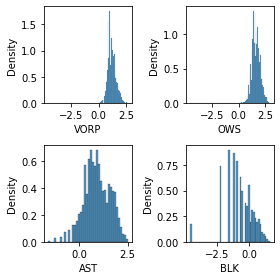

In [1009]:
features = ["VORP", "OWS", "AST", "BLK"]

plt.figure(figsize = (4, 4))
for x, y in enumerate(features):
    plt.subplot(2, 2, (x + 1))
    sns.histplot(X_train[y], stat = "density")
plt.tight_layout()

In [1016]:
def description(array):
    return np.min(array), np.mean(array), np.std(array), np.max(array)

output = X_train.iloc[:, :-3].apply(description).T
output.columns = ["min", "mean", "std", "max"]
print(output)

             min         mean         std          max
Age    18.000000    26.637609    4.287920    43.000000
GS      0.000000    36.814925   29.952121    82.000000
MP    224.000000  1708.922569  723.250204  3485.000000
FG      0.700000     5.342331    1.575484    12.900000
3P      0.000000     1.008965    0.943315     5.500000
3P%     0.000000     0.266908    0.161235     1.000000
FTA     0.000000     3.390920    1.724592    12.000000
ORB     0.100000     1.747383    1.218076     6.600000
AST    -1.609438     0.913348    0.655128     2.509599
STL     0.100000     1.115684    0.422691     3.100000
BLK    -4.605170    -0.692863    1.060961     1.570697
TOV     0.200000     2.007182    0.671626     5.700000
TS%     0.238000     0.534173    0.049545     0.730000
OWS    -4.605170     1.600180    0.405542     2.896464
WS     -2.100000     3.836916    3.088760    20.300000
OBPM   -8.800000    -0.411161    2.425413    10.300000
BPM    -9.300000    -0.372462    2.734437    13.200000
VORP   -4.

Every feature will have a standard scaler applied to it. Features that already follow a normal distribution around 0 with variance ~1 are BLK and AST. However, for convenience purposes when constructing a pipeline, we'll apply the standard scaler to every feature to avoid utilizing ColumnTransformer.

In [1017]:
X_train.columns

Index(['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'FTA', 'ORB', 'AST', 'STL', 'BLK',
       'TOV', 'TS%', 'OWS', 'WS', 'OBPM', 'BPM', 'VORP', 'WL', 'SS', 'MPG',
       'C', 'PF', 'PG', 'SF'],
      dtype='object')

In [1018]:
#instantiation
scaler = StandardScaler()
minmax = MinMaxScaler() #using minmax scaler for ordinal data 

#separating the features 
standard = ['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'FTA', 'ORB', 'AST', 'STL', 'BLK', 
            'TOV', 'TS%', 'OWS', 'WS', 'OBPM', 'BPM', 'VORP', 'WL', 'MPG']
ordinal = ["SS"]
na = ["C", "PF", "PG", "SF"]

#creating the columntransformer
scaling = ColumnTransformer([
    ("standard", StandardScaler(), standard),
    ("ordinal", MinMaxScaler(feature_range = (0, 1)), ordinal)
])

#constructing the dataframe
scaled = pd.DataFrame(scaling.fit_transform(X_train), columns = standard + ordinal)
X_train = pd.concat([scaled, X_train[na]], axis = 1)
X_train.head()

,Age,GS,MP,FG,3P,3P%,FTA,ORB,AST,STL,...,OBPM,BPM,VORP,WL,MPG,SS,C,PF,PG,SF
0,-0.848339,1.508577,2.093435,0.798274,-0.751567,0.217648,1.628837,0.535777,0.282792,-0.273685,...,1.241504,0.940764,1.526857,-1.566417,1.762336,0.097701,0.0,0.0,0.0,1.0
1,-0.615126,1.508577,1.881890,1.369527,1.050587,0.968106,0.759067,-0.613577,0.561091,0.436053,...,2.107336,1.452753,1.888090,0.045215,1.540544,0.028736,0.0,0.0,0.0,0.0
2,0.550941,0.540365,-0.034459,0.734802,-1.069595,-0.619639,1.628837,-0.367287,-0.336118,-0.983424,...,-0.572620,-0.778053,-0.838648,-0.034046,-0.407598,0.126437,1.0,0.0,0.0,0.0
3,-0.381912,0.707298,0.680370,0.544384,-0.115513,0.261063,0.991006,-0.367287,0.561091,0.909212,...,0.664283,0.099641,0.278110,-2.127846,1.178185,0.132184,0.0,0.0,0.0,0.0
4,0.550941,1.508577,1.222367,0.417439,0.202515,0.738627,0.063250,-0.777770,1.289077,1.855530,...,0.870433,0.794482,1.106912,-0.516214,0.849076,0.250000,0.0,0.0,1.0,0.0


This will be the final X_train that will be used to construct the model. I will create a data pipeline to perform the above steps.

## Checking Target Assumptions

### Linearity

The linearity between all features and the target variable can be found in EDA (part 2). However, we'll be reminded here:

In [1020]:
temp = mvp[mvp["Share"] > 0]

def find_corr(array):
    return np.corrcoef(array, temp["Share"])[0, 1]

temp[kept_features.drop(["C", "PF", "PG", "SF"])].apply(find_corr)

Age    -0.068079
GS      0.136832
MP      0.149412
FG      0.361766
3P      0.129371
3P%     0.026287
FTA     0.340368
ORB     0.056747
AST     0.165435
STL     0.065752
BLK     0.087800
TOV     0.300169
Year    0.062970
TS%     0.286017
OWS     0.491967
WS      0.589773
OBPM    0.549331
BPM     0.617964
VORP    0.633488
WL      0.338711
SS     -0.216528
MPG     0.108589
dtype: float64

As we can see, many variables do not have a strong linear relationship with the target variable. Thus, I anticipate the multiple linear regression model will not have incredible accuracy. However, I will preserve these variables due to the feature selection section. We will also tune the model with backward elimination to remove insignificant features.

### Multicollinearity

As seen in EDA, VIF scores were very high even with reduced features. Let's see if the Lasso Regressor selected features with lower multicollinearity.

In [1021]:
vf_table = pd.DataFrame()
vf_table["Feature"] = X_train.columns
vf_table["VIF"] = [variance_inflation_factor(X_train.values, x) for x in range(len(X_train.columns))]
vf_table

,Feature,VIF
0,Age,1.230300
1,GS,3.804059
2,MP,12.063969
3,FG,4.252881
4,3P,3.359359
5,3P%,2.094957
6,FTA,3.152130
7,ORB,4.896292
8,AST,4.936892
9,STL,2.191582


As we can see, through the variance inflation factor scores, there is still significant multicollinearity which will heavily impact our multiple linear regression model. However, since this is the NBA, player performance is expected to raise *all* player statistics. As a result, there is no way to significantly reduce multicollinearity to an appropriate level (VIF < 10) without removing important features in deciding the MVP. Thus, I suspect that a `Ridge Regressor`, `Random Forest`, or `Gradient-Boosted Decision Tree` algorithm would be more appropriate. However, I will still construct the linear model to explore the performance and evaluate it against other models.

# 2. Model Construction

*NOTE:* I'll construct data pipelines in sklearn to streamline the process, however I'll be displaying the code of the pre-processing through a function for transparency purposes. The pipelines will be constructed in the end when I've decided which model and hyperparameters to utilize.

## Multiple Linear Regression

First, I'll create a function to apply the pre-processing to new sets of data.

In [1026]:
mvp.columns[~(mvp.columns).isin(X_train.columns)]

Index(['Player', 'Pos', 'Tm', 'G', 'FGA', 'FG%', '3PA', '2P', '2PA', '2P%',
       'FT', 'FT%', 'DRB', 'TRB', 'PTS', 'Year', 'PER', 'USG%', 'DWS', 'WS/48',
       'DBPM', 'Share', 'Seed'],
      dtype='object')

In [1028]:
mvp.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'PER', 'TS%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Share', 'Seed', 'WL', 'SS', 'MPG'],
      dtype='object')

In [1035]:
def process_data(df):
    final_df = df.copy()
    
    #encoding
    positions = ohe.transform(final_df["Pos"].values.reshape(-1, 1))
    encoded_pos = pd.DataFrame(positions, columns = ohe.categories_[0])
    final_df.rename(columns = {"PF": "Fouls"}, inplace = True)
    final_df = final_df.join(encoded_pos)

    #dropping
    features_to_drop = ['Pos', 'G', 'FGA', 'FG%', '3PA', '2P', '2PA', '2P%', 
                        'FT', 'FT%', 'DRB', 'TRB', 'PTS', 'Year', 'PER', 'USG%', 'DWS', 
                        'WS/48', 'DBPM', 'Seed', 'SG']
    final_df = final_df.drop(features_to_drop, axis = 1)
    
    #log-transformation
    for x in ["VORP", "OWS", "AST", "BLK"]:
        if(np.min(df[x]) <= 0):
            add = abs(np.min(df[x])) + 0.01
            replacement = np.log(df[x] + add)
        else:
            replacement = np.log(df[x])
        final_df[x] = replacement

    #feature scaling 
    scaled = pd.DataFrame(scaling.transform(final_df), columns = standard + ordinal)
    final_df = pd.concat([scaled, final_df[na]], axis = 1)
    return final_df

Fitting the model:

In [1032]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [1036]:
y_pred = linreg.predict(process_data(X_test))
y_pred[y_pred < 0.1] = 0

_2021players = mvp[mvp["Year"] == 2021]["Player"]
_2021 = pd.DataFrame({"Players": _2021players, "Predicted Share": y_pred[:(len(_2021players))]})
_2022players = mvp[mvp["Year"] == 2022]["Player"]
_2022 = pd.DataFrame({"Players": _2022players, "Predicted Share": y_pred[(-len(_2022players)):]})

print("2021:\n", _2021.sort_values("Predicted Share", ascending = False).head(10))
print("\n2022:\n", _2022.sort_values("Predicted Share", ascending = False).head(10))

2021:
                     Players  Predicted Share
6987            Isaac Okoro         0.527978
6915           Nikola Jokić         0.305212
6774  Giannis Antetokounmpo         0.256422
6839          Stephen Curry         0.245809
6853            Joel Embiid         0.233691
6783           Dwayne Bacon         0.198123
6844            Luka Dončić         0.194806
6935         Damian Lillard         0.193526
6997     Aleksej Pokusevski         0.191761
7070        Zion Williamson         0.177346

2022:
                     Players  Predicted Share
7247           Nikola Jokić         0.340194
7085  Giannis Antetokounmpo         0.327986
7173            Joel Embiid         0.272132
7375            Jalen Suggs         0.233868
7420             Trae Young         0.211446
7163            Luka Dončić         0.195861
7168           Kevin Durant         0.189814
7240           LeBron James         0.189730
7303              Ja Morant         0.171867
7377           Jayson Tatum         0.16

### Determining an Error Metric

First, I'll put the actual results against the predicted results.

In [1037]:
#column names
cols = pd.MultiIndex.from_product([[2021, 2022], ["Pred_Player", "Real_Player", "Pred_Share", "Real_Share"]])

#Defining function to display result comparisons (used in future as well)
def sort_players(df, by, length): #helper function
    return df.sort_values(by, ascending = False).head(length).copy()

def display_results(predictions, award, length):
    _2021players = award[award["Year"] == 2021]["Player"]
    pred_2021 = pd.DataFrame({"Players": _2021players, "Predicted Share": predictions[:(len(_2021players))]})
    _2022players = award[award["Year"] == 2022]["Player"]
    pred_2022 = pd.DataFrame({"Players": _2022players, "Predicted Share": predictions[(-len(_2022players)):]})
    
    real_2021 = sort_players(award[award["Year"] == 2021][["Player", "Share"]], "Share", length)
    pred_2021 = sort_players(pred_2021, "Predicted Share", length)
    real_2021.reset_index(drop = True, inplace = True)
    pred_2021.reset_index(drop = True, inplace = True)

    df2021 = pd.concat([real_2021, pred_2021], axis = 1, ignore_index = True)

    real_2022 = sort_players(award[award["Year"] == 2022][["Player", "Share"]], "Share", length)
    pred_2022 = sort_players(pred_2022, "Predicted Share", length)
    real_2022.reset_index(drop = True, inplace = True)
    pred_2022.reset_index(drop = True, inplace = True)

    df2022 = pd.concat([real_2022, pred_2022], axis = 1, ignore_index = True)
    
    output = pd.concat([df2021, df2022], axis = 1, ignore_index = True)
    output = output[[2, 0, 3, 1, 6, 4, 7, 5]]
    output.columns = cols
    output.index = range(1, length + 1)
    return output

display_results(y_pred, mvp, 10)

2021                                               \
              Pred_Player            Real_Player Pred_Share Real_Share   
1             Isaac Okoro           Nikola Jokić   0.527978      0.961   
2            Nikola Jokić            Joel Embiid   0.305212      0.580   
3   Giannis Antetokounmpo          Stephen Curry   0.256422      0.449   
4           Stephen Curry  Giannis Antetokounmpo   0.245809      0.345   
5             Joel Embiid             Chris Paul   0.233691      0.138   
6            Dwayne Bacon            Luka Dončić   0.198123      0.042   
7             Luka Dončić         Damian Lillard   0.194806      0.038   
8          Damian Lillard          Julius Randle   0.193526      0.020   
9      Aleksej Pokusevski            Rudy Gobert   0.191761      0.008   
10        Zion Williamson      Russell Westbrook   0.177346      0.005   

                     2022                                               
              Pred_Player            Real_Player Pred_Share Real_Share  
1            Nikola Jokić           Nikola Jokić   0.340194      0.875  
2   Giannis Antetokounmpo            Joel Embiid   0.327986      0.706  
3             Joel Embiid  Giannis Antetokounmpo   0.272132      0.595  
4             Jalen Suggs           Devin Booker   0.233868      0.216  
5              Trae Young            Luka Dončić   0.211446      0.146  
6             Luka Dončić           Jayson Tatum   0.195861      0.043  
7            Kevin Durant              Ja Morant   0.189814      0.010  
8            LeBron James          Stephen Curry   0.189730      0.004  
9               Ja Morant             Chris Paul   0.171867      0.002  
10           Jayson Tatum          DeMar DeRozan   0.163412      0.001

The predicted shares are no where close to the real shares in an MVP race. I suspect the amount of 0 values messes with the distribution of the target variable. Additionally, the algorithm also inherently predicts linearly, whereas in reality the shares are more exponential. Therefore, I'll be utilizing a different error metric that focuses on the relativity of a player ranking and the accuracy of predicting that a player will receive an MVP award.

However, I'll still look and evaluate common error metrics

In [1038]:
mean_absolute_error(y_pred, y_test)

0.014780319361524673

In [1039]:
cross_val_score(LinearRegression(), X_train, y_train, cv = 10, scoring = "neg_mean_absolute_error").mean()

-0.02650913146024041

Seemingly, the model performs well in predicting within .05 of the shares of the real data. However, this may be a signal of overfitting. Since I'm still more concerned about the relativity of the shares, I'll create a new error metric:

**Custom Error Metric** 

- 60% of the evaluation focuses on the ability to predict the relative ranking of the players that *received* MVP votes. 1 point will be awarded for being correctly ranked, 0.8 for being 1 place off, 0.6 for being 2 places off, 0.4 for being 3 places off, 0.2 for being 4 places off, and 0 for being 5 more places off.
    - If a player had over .1 in award shares, they'll be pooled in being weighted 75% of this category. If a player received less than .1 in award shares, they'll be pooled in being weighted 25% of this category. This is a result from players receiving over .1 in award shares being more significant to me.  
- 40% of the evaluation focuses on the ability to predict the players that did not receive MVP votes. The % of correctly predicted 0 MVP vote players will be taken.

In [629]:
def count(lst): #helper function
    return sum(bool(x) for x in lst) / len(lst)

def custom_error(pred, year):
    real_shares = mvp[mvp["Year"] == year][["Player", "Share"]].copy()
    real_shares = real_shares.sort_values("Share", ascending = False)
    real_no_votes = real_shares[real_shares["Share"] == 0]
    real_shares = real_shares[real_shares["Share"] > 0]
    real_shares["Rank"] = np.arange(len(real_shares)) + 1
    
    pred_shares = mvp[mvp["Year"] == year][["Player"]].copy()
    pred_shares["Share"] = pred
    pred_shares.sort_values("Share", ascending = False, inplace = True)
    pred_shares["Rank"] = np.arange(len(pred_shares)) + 1
    
    sum_one = 0
    count_one = 0
    sum_two = 0
    count_two = 0
    for x in real_shares["Player"].values:
        rank = real_shares[real_shares["Player"] == x]["Rank"].values[0]
        pred_rank = pred_shares[pred_shares["Player"] == x]["Rank"].values[0]
        
        points = 1 - 0.2 * abs(rank - pred_rank) 
        if points < 0:
            points = 0
        
        if real_shares[real_shares["Player"] == x]["Share"].values[0] < 0.1:
            sum_two += points 
            count_two += 1
        else: 
            sum_one += points
            count_one += 1
        
    relative_score = (0.75 * (sum_one / count_one)) + (0.25 * (sum_two / count_two))
    
    real_players = real_no_votes["Player"].values
    pred_players = pred_shares[pred_shares["Share"] == 0]["Player"].values
    
    zero_score = count([player in pred_players for player in real_players])
    
    return (relative_score + zero_score) / 2

In [1040]:
np.mean([custom_error(y_pred[:269], 2021), custom_error(y_pred[-297:], 2022)])

0.7466790021929824

As we can see, even though I achieved an acceptable MAE score, the model does not perform accurately in the way that I would like. Therefore, I'll be exploring other algorithms to see if I can get at least a score of 0.75 using my error metric.

## Ridge Regressor

I will slightly adjust the pre-processing steps for the Ridge Regressor to include more features since Ridge Regression is more resistant to Multicollinearity than the multiple linear regression model, and is naturally able to handle more features. Thus, I'll use the f-regression table I constructed earlier to add back important features. Additionally, I'll take into consider how the L1 regularization model reduced the features as Ridge will include *all* features in the formula. 

Many pre-processing steps such as standardization and encoding will remain the same.

In [1045]:
#fitting new scaler with new variables 
X_train_ridge = X[(X["Year"] != 2022) & (X["Year"] != 2021)].reset_index(drop = True)
X_train_ridge.drop(["Player", "Tm"], axis = 1, inplace = True)

standard_ridge = ['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'ORB', 'AST', 'STL', 'BLK', 
            'TOV', 'PTS', 'TS%', 'OWS', 'WS/48', 'OBPM', 'BPM', 'VORP', 'WL', 'MPG']

scaling_ridge = ColumnTransformer([
    ("standard", StandardScaler(), standard_ridge),
    ("ordinal", MinMaxScaler(feature_range = (0, 1)), ordinal)
])

scaling_ridge.fit(X_train_ridge)

ColumnTransformer(transformers=[('standard', StandardScaler(),
                                 ['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'ORB',
                                  'AST', 'STL', 'BLK', 'TOV', 'PTS', 'TS%',
                                  'OWS', 'WS/48', 'OBPM', 'BPM', 'VORP', 'WL',
                                  'MPG']),
                                ('ordinal', MinMaxScaler(), ['SS'])])

In [1046]:
def process_data_ridge(df):
    final_df = df.copy()
    
    #encoding
    positions = ohe.transform(final_df["Pos"].values.reshape(-1, 1))
    encoded_pos = pd.DataFrame(positions, columns = ohe.categories_[0])
    final_df.rename(columns = {"PF": "Fouls"}, inplace = True)
    final_df = final_df.join(encoded_pos)

    #dropping
    features_to_drop = ['Pos', 'G', 'FGA', 'FG%', '3PA', '2P', '2PA', 
                        '2P%', 'FT', 'FTA', 'DRB', 'TRB', 'Fouls', 'Year', 
                        'PER', 'USG%', 'DWS', 'WS', 'DBPM', 'Seed', 'SG']
    
    final_df = final_df.drop(features_to_drop, axis = 1)
    
    #log-transformation
    for x in ["VORP", "OWS", "AST", "BLK", "FT"]:
        if(np.min(df[x]) <= 0):
            add = abs(np.min(df[x])) + 0.01
            replacement = np.log(df[x] + add)
        else:
            replacement = np.log(df[x])
        final_df[x] = replacement

    #feature scaling 
    scaled = pd.DataFrame(scaling_ridge.transform(final_df), columns = standard_ridge + ordinal)
    final_df = pd.concat([scaled, final_df[na]], axis = 1)
    return final_df

Fitting the model:

In [1047]:
#I'll be utilizing GridSearchCV to determine the best alpha level for the Ridge regressor.
model = Ridge()
parameters = {'alpha': np.arange(1, 11, 1)}
ridge_reg = GridSearchCV(estimator = model, param_grid = parameters, cv = 3, scoring = "neg_mean_squared_error")
ridge_reg.fit(process_data_ridge(X_train_ridge), y_train)
pd.DataFrame(ridge_reg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025534,0.025995,0.001966,0.000241,1,{'alpha': 1},-0.004140,-0.003899,-0.003926,-0.003988,0.000108,10
1,0.002749,0.000349,0.001019,0.000056,2,{'alpha': 2},-0.004116,-0.003905,-0.003905,-0.003976,0.000099,9
2,0.002750,0.001141,0.002841,0.001780,3,{'alpha': 3},-0.004098,-0.003912,-0.003891,-0.003967,0.000093,8
3,0.002108,0.000110,0.001130,0.000172,4,{'alpha': 4},-0.004084,-0.003919,-0.003882,-0.003962,0.000088,6
4,0.001913,0.000044,0.000925,0.000031,5,{'alpha': 5},-0.004073,-0.003926,-0.003877,-0.003959,0.000084,4
5,0.002087,0.000228,0.000957,0.000043,6,{'alpha': 6},-0.004065,-0.003933,-0.003874,-0.003957,0.000080,1
6,0.001961,0.000186,0.001675,0.000562,7,{'alpha': 7},-0.004059,-0.003940,-0.003873,-0.003957,0.000077,2
7,0.002627,0.001359,0.000850,0.000037,8,{'alpha': 8},-0.004054,-0.003947,-0.003874,-0.003959,0.000074,3
8,0.001889,0.000256,0.000846,0.000013,9,{'alpha': 9},-0.004050,-0.003954,-0.003877,-0.003961,0.000071,5
9,0.001730,0.000092,0.000905,0.000073,10,{'alpha': 10},-0.004048,-0.003961,-0.003881,-0.003963,0.000068,7


In [1048]:
ridgereg = ridge_reg.best_estimator_
ridgereg.fit(process_data_ridge(X_train_ridge), y_train)

Ridge(alpha=6)

In [1049]:
y_pred_ridge = ridgereg.predict(process_data_ridge(X_test))
y_pred_ridge[y_pred_ridge < 0.1] = 0

display_results(y_pred_ridge, mvp, 10)

2021                                               \
              Pred_Player            Real_Player Pred_Share Real_Share   
1             Joel Embiid           Nikola Jokić   0.252451      0.961   
2   Giannis Antetokounmpo            Joel Embiid   0.250273      0.580   
3           Stephen Curry          Stephen Curry   0.244205      0.449   
4            Nikola Jokić  Giannis Antetokounmpo   0.233459      0.345   
5             Luka Dončić             Chris Paul   0.214589      0.138   
6            LeBron James            Luka Dončić   0.184726      0.042   
7          Damian Lillard         Damian Lillard   0.170559      0.038   
8              Trae Young          Julius Randle   0.168492      0.020   
9             Isaac Okoro            Rudy Gobert   0.167185      0.008   
10        Zion Williamson      Russell Westbrook   0.164304      0.005   

                     2022                                               
              Pred_Player            Real_Player Pred_Share Real_Share  
1   Giannis Antetokounmpo           Nikola Jokić   0.301906      0.875  
2            Nikola Jokić            Joel Embiid   0.284145      0.706  
3             Joel Embiid  Giannis Antetokounmpo   0.253574      0.595  
4             Luka Dončić           Devin Booker   0.221272      0.216  
5              Trae Young            Luka Dončić   0.206674      0.146  
6            Kevin Durant           Jayson Tatum   0.196501      0.043  
7            LeBron James              Ja Morant   0.189604      0.010  
8               Ja Morant          Stephen Curry   0.189329      0.004  
9        Donovan Mitchell             Chris Paul   0.153713      0.002  
10           Jayson Tatum          DeMar DeRozan   0.150725      0.001

In [1050]:
print(mean_absolute_error(y_pred_ridge, y_test))
print(cross_val_score(Ridge(alpha = 4), process_data_ridge(X_train_ridge), y_train, 
                cv = 10, scoring = "neg_mean_absolute_error").mean())

0.01188279087366445
-0.02647333154211916


The model performs similarly to the multiple regression model utilizing the mean absolute error statistic, however let's measure using my custom error metric.

In [1051]:
print("2021 Accuracy: ", custom_error(y_pred_ridge[:269], 2021))
print("2022 Accuracy: ", custom_error(y_pred_ridge[-297:], 2022))
print("Combined: ", np.mean([custom_error(y_pred_ridge[:269], 2021), custom_error(y_pred_ridge[-297:], 2022)]))

2021 Accuracy:  0.7271875000000001
2022 Accuracy:  0.7518796992481203
Combined:  0.7395335996240602


As we can see, the model did perform slightly better than the linear regression model. However, let's see if we can better results with other algorithms.

## Support Vector Regressor

In [1052]:
model = SVR()
param_grid = {"kernel": ("linear", "rbf", "poly"), "C": (1, 1.5, 2), "epsilon": (0.1, 0.25, 0.5), "degree": (1,2,3,4)}
svr_model = GridSearchCV(model, param_grid, scoring = "neg_mean_squared_error")
svr_model.fit(X_train, y_train)
svr_model.best_params_

{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}

In [1053]:
svr = SVR(kernel = "poly", epsilon = 0.1, degree = 2, C = 1)
svr.fit(X_train, y_train)

SVR(C=1, degree=2, kernel='poly')

In [1055]:
y_pred_svr = svr.predict(process_data(X_test))
y_pred_svr[y_pred_svr < 0] = 0

display_results(y_pred_svr, mvp, 10)

2021                                               \
              Pred_Player            Real_Player Pred_Share Real_Share   
1            Nikola Jokić           Nikola Jokić   0.630804      0.961   
2   Giannis Antetokounmpo            Joel Embiid   0.382409      0.580   
3             Joel Embiid          Stephen Curry   0.193194      0.449   
4             Luka Dončić  Giannis Antetokounmpo   0.157617      0.345   
5         Zion Williamson             Chris Paul   0.126374      0.138   
6           Stephen Curry            Luka Dončić   0.122521      0.042   
7            Bradley Beal         Damian Lillard   0.112578      0.038   
8           Kawhi Leonard          Julius Randle   0.104709      0.020   
9              Trae Young            Rudy Gobert   0.097874      0.008   
10          Julius Randle      Russell Westbrook   0.083160      0.005   

                     2022                                               
              Pred_Player            Real_Player Pred_Share Real_Share  
1            Nikola Jokić           Nikola Jokić   0.768024      0.875  
2   Giannis Antetokounmpo            Joel Embiid   0.574513      0.706  
3             Joel Embiid  Giannis Antetokounmpo   0.284948      0.595  
4            LeBron James           Devin Booker   0.224052      0.216  
5             Luka Dončić            Luka Dončić   0.198975      0.146  
6            Kevin Durant           Jayson Tatum   0.168634      0.043  
7              Trae Young              Ja Morant   0.158264      0.010  
8               Ja Morant          Stephen Curry   0.139961      0.004  
9            Jayson Tatum             Chris Paul   0.128496      0.002  
10       Donovan Mitchell          DeMar DeRozan   0.116108      0.001

In [1057]:
print(mean_absolute_error(y_pred_svr, y_test))
print(cross_val_score(SVR(kernel = "rbf", degree = 1, C = 2), X_train, y_train, 
                cv = 10, scoring = "neg_mean_absolute_error").mean())

0.009858057574405058
-0.03994158748362802


The cross validated scores show that this model does not perform well despite predicting the MVP correctly in both 2022 and 2021. However, after the first 5 players, the model becomes incredibly inaccurate.

In [1058]:
print("2021 Accuracy: ", custom_error(y_pred_svr[:269], 2021))
print("2022 Accuracy: ", custom_error(y_pred_svr[-297:], 2022))
print("Combined: ", np.mean([custom_error(y_pred_svr[:269], 2021), custom_error(y_pred_svr[-297:], 2022)]))

2021 Accuracy:  0.663515625
2022 Accuracy:  0.726516290726817
Combined:  0.6950159578634085


This model performs severely worse than the linear model and Ridge regressor model.

## Random Forest Regressor

The preprocessing steps for the Random Forest Regressor will be slightly different.

In [1059]:
def process_data_rfr(df):
    final_df = df.copy()
    
    #encoding
    positions = ohe.transform(final_df["Pos"].values.reshape(-1, 1))
    encoded_pos = pd.DataFrame(positions, columns = ohe.categories_[0])
    final_df.rename(columns = {"PF": "Fouls"}, inplace = True)
    final_df = final_df.join(encoded_pos)

    #dropping
    features_to_drop = ['Pos', 'G', 'FGA', 'FG%', '3PA', '2P', '2PA', '2P%', 
                        'FT', 'FT%', 'DRB', 'TRB', 'Year', 'PER', 'USG%', 'DWS', 
                        'WS/48', 'OBPM', 'DBPM', 'Seed', 'SG']
    final_df = final_df.drop(features_to_drop, axis = 1)
    
    return final_df

In [1281]:
testset.drop("PF", axis = 1).join(encoded_pos)

,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,VORP,Seed,WL,SS,MPG,C,PF,PG,SF,SG
1705,PF,29,72,30,1961,6.1,11.6,0.525,0.1,0.4,...,1.4,8.0,0.537,72,27.236111,NaN,NaN,NaN,NaN,NaN
1706,PF,27,54,20,701,6.2,12.7,0.490,0.1,0.1,...,-0.1,7.0,0.500,144,12.981481,NaN,NaN,NaN,NaN,NaN
1707,SG,30,78,78,3022,8.1,17.9,0.454,3.2,7.8,...,4.9,11.0,0.427,13,38.743590,NaN,NaN,NaN,NaN,NaN
1708,PG,24,51,9,978,4.7,10.1,0.471,0.4,1.3,...,0.1,11.0,0.402,146,19.176471,NaN,NaN,NaN,NaN,NaN
1709,PG,29,63,63,2431,4.1,10.9,0.379,1.5,4.6,...,1.0,12.0,0.415,214,38.587302,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,PG,30,59,56,1874,5.1,11.6,0.442,2.1,5.5,...,1.5,2.0,0.634,134,31.762712,NaN,NaN,NaN,NaN,NaN
1991,PF,19,79,7,1952,4.3,9.8,0.443,0.2,1.0,...,-0.7,14.0,0.317,185,24.708861,NaN,NaN,NaN,NaN,NaN
1992,PG,23,58,12,1531,6.3,14.8,0.424,1.7,4.5,...,0.8,8.0,0.488,65,26.396552,NaN,NaN,NaN,NaN,NaN
1993,SF,24,49,16,1013,4.6,9.0,0.508,0.8,2.1,...,0.3,15.0,0.280,203,20.673469,NaN,NaN,NaN,NaN,NaN


In [1060]:
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(process_data_rfr(X_train_ridge), y_train) #note: X_train_ridge applies correctly in this scenario

RandomForestRegressor()

In [1062]:
y_pred_rfr = rfr.predict(process_data_rfr(X_test))
y_pred_rfr[y_pred_rfr < 0] = 0

display_results(y_pred_rfr, mvp, 10)

2021                                               \
              Pred_Player            Real_Player Pred_Share Real_Share   
1            Nikola Jokić           Nikola Jokić    0.57673      0.961   
2             Joel Embiid            Joel Embiid    0.42450      0.580   
3           Stephen Curry          Stephen Curry    0.20471      0.449   
4   Giannis Antetokounmpo  Giannis Antetokounmpo    0.19994      0.345   
5             Luka Dončić             Chris Paul    0.15490      0.138   
6          Damian Lillard            Luka Dončić    0.09863      0.042   
7              Trae Young         Damian Lillard    0.06908      0.038   
8         Zion Williamson          Julius Randle    0.03140      0.020   
9            LeBron James            Rudy Gobert    0.03107      0.008   
10           Bradley Beal      Russell Westbrook    0.02794      0.005   

                     2022                                               
              Pred_Player            Real_Player Pred_Share Real_Share  
1   Giannis Antetokounmpo           Nikola Jokić    0.50573      0.875  
2            Nikola Jokić            Joel Embiid    0.50395      0.706  
3             Joel Embiid  Giannis Antetokounmpo    0.41902      0.595  
4             Luka Dončić           Devin Booker    0.25873      0.216  
5            LeBron James            Luka Dončić    0.12424      0.146  
6              Trae Young           Jayson Tatum    0.07764      0.043  
7              Chris Paul              Ja Morant    0.06365      0.010  
8            Kevin Durant          Stephen Curry    0.04609      0.004  
9               Ja Morant             Chris Paul    0.04262      0.002  
10          Stephen Curry          DeMar DeRozan    0.01308      0.001

In [1063]:
print(mean_absolute_error(y_pred_rfr, y_test))
print(cross_val_score(RandomForestRegressor(), process_data_rfr(X_train_ridge), y_train, 
                cv = 10, scoring = "neg_mean_absolute_error").mean())

0.0052739222614840995
-0.006647118910072825


In [1064]:
print("2021 Accuracy: ", custom_error(y_pred_rfr[:269], 2021))
print("2022 Accuracy: ", custom_error(y_pred_rfr[-297:], 2022))
print("Combined: ", np.mean([custom_error(y_pred_rfr[:269], 2021), custom_error(y_pred_rfr[-297:], 2022)]))

2021 Accuracy:  0.7445312500000001
2022 Accuracy:  0.7048245614035087
Combined:  0.7246779057017544


As we can see, the Random Forest regressor model performed the best in minimizing the MAE for the Share, AND maximizing the accuracy score using my custom metric. Therefore, I believe that a decision tree regressor may be the best algorithm for this dataset. Thus, I'll try constructing an *Extreme Gradient-Boosted Decision Tree Regressor* and compare it to the Random Forest Regressor.

## XGBoost Regressor

In [1070]:
mvp.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'PER', 'TS%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Share', 'Seed', 'WL', 'SS', 'MPG'],
      dtype='object')

In [1075]:
kept_features

Index(['Age', 'GS', 'MP', 'FG', '3P', '3P%', 'FTA', 'ORB', 'AST', 'STL', 'BLK',
       'TOV', 'Year', 'TS%', 'OWS', 'WS', 'OBPM', 'BPM', 'VORP', 'WL', 'SS',
       'MPG', 'C', 'PF', 'PG', 'SF'],
      dtype='object')

In [1104]:
def process_data_xgb(df):
    final_df = df.copy()
    
    #encoding
    positions = ohe.transform(final_df["Pos"].values.reshape(-1, 1))
    encoded_pos = pd.DataFrame(positions, columns = ohe.categories_[0])
    final_df.rename(columns = {"PF": "Fouls"}, inplace = True)
    final_df = final_df.join(encoded_pos)

    #dropping
    features_to_drop = ['Pos', 'G', 'MP', 'FGA', 'FG%', '3PA', '2P', '2PA', 
                        '2P%', 'FT', 'DRB', 'TRB', 'Fouls', 'Year',
                        'USG%', 'DWS', 'WS', 'WS/48', 'DBPM', 'OBPM', 'TS%', 'Seed', 'SG']
    final_df = final_df.drop(features_to_drop, axis = 1)
    
    return final_df

In [1105]:
parameters = {'max_depth': [3, 5, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.25, 0.5],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.5, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
model = xgb.XGBRegressor()

xgb_model = RandomizedSearchCV(estimator = model,
                              param_distributions = parameters,
                              scoring = "neg_mean_squared_error",
                              verbose = 1)

xgb_model.fit(process_data_xgb(X_train_ridge), y_train) #Using ridge training dataset again (not scaled)
xgb_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'subsample': 0.7,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.7999999999999999}

In [1106]:
xgbr = xgb.XGBRegressor(n_estimators = 100,
                       subsample = 0.7,
                       max_depth = 10,
                       learning_rate = 0.1,
                       colsample_bytree = 0.5,
                       colsample_bylevel = 0.8)
xgbr.fit(process_data_xgb(X_train_ridge), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [1107]:
y_pred_xgb = xgbr.predict(process_data_xgb(X_test))
y_pred_xgb[y_pred_xgb < 0.01] = 0

display_results(y_pred_xgb, mvp, 10)

2021                                               \
              Pred_Player            Real_Player Pred_Share Real_Share   
1            Nikola Jokić           Nikola Jokić   0.850982      0.961   
2             Joel Embiid            Joel Embiid   0.379030      0.580   
3           Stephen Curry          Stephen Curry   0.310502      0.449   
4   Giannis Antetokounmpo  Giannis Antetokounmpo   0.180406      0.345   
5             Luka Dončić             Chris Paul   0.167969      0.138   
6            LeBron James            Luka Dončić   0.099236      0.042   
7            Bradley Beal         Damian Lillard   0.087907      0.038   
8         Zion Williamson          Julius Randle   0.070360      0.020   
9          Damian Lillard            Rudy Gobert   0.059986      0.008   
10      Russell Westbrook      Russell Westbrook   0.012727      0.005   

                     2022                                               
              Pred_Player            Real_Player Pred_Share Real_Share  
1   Giannis Antetokounmpo           Nikola Jokić   0.815224      0.875  
2            Nikola Jokić            Joel Embiid   0.654954      0.706  
3             Joel Embiid  Giannis Antetokounmpo   0.633546      0.595  
4             Luka Dončić           Devin Booker   0.257890      0.216  
5               Ja Morant            Luka Dončić   0.133445      0.146  
6            Kevin Durant           Jayson Tatum   0.111797      0.043  
7            LeBron James              Ja Morant   0.106373      0.010  
8           Stephen Curry          Stephen Curry   0.047592      0.004  
9              Trae Young             Chris Paul   0.039468      0.002  
10             Chris Paul          DeMar DeRozan   0.033920      0.001

In [1108]:
print(mean_absolute_error(y_pred_xgb, y_test)) 
print(cross_val_score(xgb.XGBRegressor(n_estimators = 500, subsample = 0.6, max_depth = 5, learning_rate = 0.01,
                                       colsample_bytree = 0.6,colsample_bylevel = 0.6), 
                      process_data_xgb(X_train_ridge), y_train, cv = 10, 
                      scoring = "neg_mean_absolute_error").mean()) 

0.004699097003432339
-0.009719106512645074


In [1109]:
print("2021 Accuracy: ", custom_error(y_pred_xgb[:269], 2021))
print("2022 Accuracy: ", custom_error(y_pred_xgb[-297:], 2022))
print("Combined: ", np.mean([custom_error(y_pred_xgb[:269], 2021), custom_error(y_pred_xgb[-297:], 2022)]))

2021 Accuracy:  0.837890625
2022 Accuracy:  0.7733709273182957
Combined:  0.8056307761591479


This model outperformed all other models! Even though my error metric returns a similar result in both the RandomForestRegressor and XGBoost, the MAE score supports the XGBoost algorithm. Therefore, I'll proceed with this algorithm and apply it to the rest of the awards.

# 3. Summary of Results

Below is a table of the results of the models and their relative performance.

In [1110]:
results = pd.DataFrame()
results["Model"] = ["Linear", "Ridge", "SVR", "Random Forest", "XGBoost"]
results["MAE"] = [mean_absolute_error(y_pred, y_test),
                  mean_absolute_error(y_pred_ridge, y_test),
                  mean_absolute_error(y_pred_svr, y_test),
                  mean_absolute_error(y_pred_rfr, y_test),
                  mean_absolute_error(y_pred_xgb, y_test)]

def mean_error(predictions):
    return np.mean([custom_error(predictions[:269], 2021), custom_error(predictions[-297:], 2022)])

error_scores = list(map(mean_error, [y_pred, y_pred_ridge, y_pred_svr, y_pred_rfr, y_pred_xgb]))
results["Custom Error Score"] = error_scores

def mvp_prediction(predictions):
    return display_results(predictions, mvp, 1)[2021]["Pred_Player"].values[0], display_results(predictions, mvp, 1)[2022]["Pred_Player"].values[0]

mvp_predictions = pd.DataFrame((map(mvp_prediction, 
                                    [y_pred, y_pred_ridge, y_pred_svr, y_pred_rfr, y_pred_xgb])),
                               columns = ("2021 MVP", "2022 MVP"))
results = results.join(mvp_predictions)

results

,Model,MAE,Custom Error Score,2021 MVP,2022 MVP
0,Linear,0.014780,0.746679,Isaac Okoro,Nikola Jokić
1,Ridge,0.011883,0.739534,Joel Embiid,Giannis Antetokounmpo
2,SVR,0.009858,0.695016,Nikola Jokić,Nikola Jokić
3,Random Forest,0.005274,0.724678,Nikola Jokić,Giannis Antetokounmpo
4,XGBoost,0.004699,0.805631,Nikola Jokić,Giannis Antetokounmpo


## Backtesting Model

With this new model, I'll now create a backtest to predict the MVP (Player with highest voting share) every year from 2006-2022. 

In [1323]:
mvp[mvp["Player"] == "Giannis Antetokounmpo"].index[0]

4453

In [1335]:
temp.sort_values("Pred_Share", ascending = False).iloc[0, 1]

0.82870346

In [1338]:
#creating dataframe for real MVPs
real_mvps = pd.DataFrame() 
players = []
shares = []
for x in range(2006, 2023):
    players.append(mvp[mvp["Year"] == x].sort_values("Share", ascending = False).iloc[0]["Player"])
    shares.append(mvp[mvp["Year"] == x].sort_values("Share", ascending = False).iloc[0]["Share"])

real_mvps["Year"] = range(2006, 2023)
real_mvps["Real MVP"] = players
real_mvps["Real Share"] = shares

#creating dataframe for predictions 
agg = pd.concat([X_train_ridge, X_test], axis = 0).reset_index(drop = True)
pred_mvps = pd.DataFrame()
players_2 = []
shares_2 = []
for x in range(2006, 2023):
    trainset = agg[agg["Year"] < x] #due to temporal data, we'll only include years before 
    testset = agg[agg["Year"] == x]
    xgbr.fit(process_data_xgb(trainset), mvp[mvp["Year"] < x]["Share"])
    predict = xgbr.predict(process_data_xgb(testset))
    
    temp = pd.DataFrame({"Player": mvp[mvp["Year"] == x]["Player"], "Pred_Share": predict})
    temp.reset_index(drop = True, inplace = True)
    pred_mvp = temp.sort_values("Pred_Share", ascending = False).iloc[0, 0]
    pred_share = temp.sort_values("Pred_Share", ascending = False).iloc[0, 1]
    players_2.append(pred_mvp)
    shares_2.append(pred_share)

pred_mvps["Year"] = range(2006, 2023)
pred_mvps["Pred MVP"] = players_2
pred_mvps["Pred Share"] = shares_2 

output = pd.merge(real_mvps, pred_mvps, on = "Year")
output[["Year", "Pred MVP", "Real MVP", "Pred Share", "Real Share"]]

,Year,Pred MVP,Real MVP,Pred Share,Real Share
0,2006,Kobe Bryant,Steve Nash,0.535109,0.739
1,2007,Steve Nash,Dirk Nowitzki,0.907199,0.882
2,2008,LeBron James,Kobe Bryant,0.430484,0.873
3,2009,LeBron James,LeBron James,0.655591,0.969
4,2010,LeBron James,LeBron James,0.889428,0.980
5,2011,LeBron James,Derrick Rose,0.540028,0.977
6,2012,LeBron James,LeBron James,0.553897,0.888
7,2013,LeBron James,LeBron James,0.776861,0.998
8,2014,Kevin Durant,Kevin Durant,0.645513,0.986
9,2015,Stephen Curry,Stephen Curry,0.696836,0.922


In [1265]:
np.sum(output["Pred MVP"] == output["Real MVP"])

10

I was able to successfully predict 10/16 MVPs using this model. This is also considering controversial MVPs such as Derrick, Russell Westbrook, and Steve Nash

# 4. Constructing Data Pipelines for Each Award

*NOTE:* We'll be utilizing the XGBoost algorithm with the same hyperparameters. Each award can have its own model tuning and selection process, however due to the similarity in the features and voting process for the NBA awards, this model should be sufficient in predicting within my desired range. 

1. Train/Test Split
2. Encode Position
3. Utilize Lasso Reduction to reduce the features
4. Filter out the features 
5. Utilize RandomizedGridSearch for model tuning 
6. Fit training data into XGBRegressor model
7. Output results

In [1131]:
#function that takes unprocessed dataframe and returns the train and test datasets that are processed and ready for model training
def construct_datasets(df):
    #Train/Test Split
    X = df.drop(["Player", "Share"], axis = 1)
    y = df["Share"]
    
    X_train = X[(X["Year"] != 2022) & (X["Year"] != 2021)].reset_index(drop = True)
    X_test = X[~((X["Year"] != 2022) & (X["Year"] != 2021))].reset_index(drop = True)
    cutoff = len(X) - len(X_train) #represents amount of players in 2021 and 2022
    y_train = y[:-cutoff]
    y_test = y.tail(cutoff)

    #Encoding
    ohe = OneHotEncoder(sparse = False)
    new_pos = ohe.fit_transform(X_train["Pos"].values.reshape(-1, 1))
    df = pd.DataFrame(new_pos, columns = ohe.categories_[0])
    X_train.rename(columns = {"PF": "Fouls"}, inplace = True) #PF already exists in feature names 
    X_train = X_train.join(df)
    
    positions = ohe.transform(X_test["Pos"].values.reshape(-1, 1))
    encoded_pos = pd.DataFrame(positions, columns = ohe.categories_[0])
    X_test.rename(columns = {"PF": "Fouls"}, inplace = True)
    X_test = X_test.join(encoded_pos)
    
    X_train.drop("Pos", axis = 1, inplace = True)
    X_test.drop("Pos", axis = 1, inplace = True)
    
    #Using Lasso Regressor for Feature Selection
    lasso = Pipeline([
        ("scaler", StandardScaler()),
        ("ls", Lasso(alpha = 0.0005, random_state = 10))
    ])

    feature_select = SelectFromModel(lasso).fit(X_train, y_train)
    coefficients = feature_select.estimator_["ls"].coef_
    kept_features = list(X_train.columns[coefficients != 0])
    
    #searching for best parameters for XGBoost
    parameters = {'max_depth': [3, 5, 10, 15, 20],
               'learning_rate': [0.01, 0.1, 0.25, 0.5],
               'subsample': np.arange(0.5, 1.0, 0.1),
               'colsample_bytree': np.arange(0.5, 1.0, 0.1),
               'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
               'n_estimators': [100, 500, 1000]}
    model = xgb.XGBRegressor()

    xgb_model = RandomizedSearchCV(estimator = model,
                                  param_distributions = parameters,
                                  scoring = "neg_mean_squared_error",
                                  verbose = 1)

    xgb_model.fit(X_train[kept_features], y_train) #Using ridge training dataset again
    
    #returns all the necessary information
    return X_train[kept_features], X_test[kept_features], y_train, y_test, xgb_model.best_params_

## ROY

In [1132]:
#Getting rid of missing data using knowledge from EDA
roy.drop(["Unnamed: 0", "Tm"], axis = 1, inplace = True)
roy["3P%"].fillna(0, inplace = True)
roy["Share"].fillna(0, inplace = True)
roy.dropna(axis = 0, inplace = True)

In [1133]:
roy_datasets = construct_datasets(roy)

X_train_roy = roy_datasets[0]
X_test_roy = roy_datasets[1]
y_train_roy = roy_datasets[2]
y_test_roy = roy_datasets[3]
print("Parameters for Model: ", roy_datasets[4])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Parameters for Model:  {'subsample': 0.7999999999999999, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7999999999999999}


In [1134]:
print("Kept Features: ", X_train_roy.columns.values)

Kept Features:  ['Age' 'G' 'GS' 'MP' 'FG' 'FG%' '3P%' '2P%' 'FT' 'FT%' 'ORB' 'DRB' 'AST'
 'STL' 'BLK' 'TOV' 'Fouls' 'Year' 'PER' 'TS%' 'DWS' 'WS/48' 'DBPM' 'BPM'
 'VORP' 'Seed' 'WL' 'SS' 'MPG' 'PF' 'SG']


In [1287]:
xgbr_roy = xgb.XGBRegressor(n_estimators = 500,
                       subsample = 0.8,
                       max_depth = 5,
                       learning_rate = 0.01,
                       colsample_bytree = 0.8,
                       colsample_bylevel = 0.8)

xgbr_roy.fit(X_train_roy, y_train_roy)
y_pred_roy = xgbr_roy.predict(X_test_roy)
y_pred_roy[y_pred_roy < 0.05] = 0

Evaluating Results:

In [1288]:
display_results(y_pred_roy, roy, 7)

2021                                           \
         Pred_Player        Real_Player Pred_Share Real_Share   
1    Anthony Edwards        LaMelo Ball   0.343941      0.939   
2  Tyrese Haliburton    Anthony Edwards   0.138295      0.624   
3        LaMelo Ball  Tyrese Haliburton   0.135329      0.230   
4        Isaac Okoro         Saddiq Bey   0.113235      0.006   
5  Immanuel Quickley   Precious Achiuwa   0.053184      0.000   
6   Precious Achiuwa  Immanuel Quickley   0.000000      0.000   
7         Zeke Nnaji     Onyeka Okongwu   0.000000      0.000   

              2022                                         
       Pred_Player      Real_Player Pred_Share Real_Share  
1      Evan Mobley   Scottie Barnes   0.497229      0.756  
2   Scottie Barnes      Evan Mobley   0.496494      0.726  
3  Cade Cunningham  Cade Cunningham   0.288039      0.306  
4      Jalen Green      Jalen Green   0.217565      0.006  
5     Franz Wagner     Franz Wagner   0.210502      0.004  
6      Josh Giddey    Herbert Jones   0.173029      0.002  
7    Jose Alvarado    Jose Alvarado   0.000000      0.000

In [1289]:
print("MAE: ", mean_absolute_error(y_pred_roy, y_test_roy))

MAE:  0.03652517786799971


## SMOY

In [1290]:
smoy.drop(["Unnamed: 0", "Tm"], axis = 1, inplace = True)
smoy["3P%"].fillna(0, inplace = True)
smoy["Share"].fillna(0, inplace = True)
smoy.dropna(axis = 1, inplace = True)
smoy.isna().sum().sum()

0

As discovered in EDA, SMOY has more positions than necessary. Therefore, we'll convert positions to fit one of the five from below. (Whatever comes first in the string)

In [819]:
smoy["Pos"].unique()

array(['C', 'PG', 'SG', 'PF', 'SF', 'SF-SG', 'PF-SF', 'PG-SG', 'C-PF',
       'PF-C', 'SG-PG', 'SG-SF', 'SF-PF', 'SG-PF', 'SG-PG-SF'],
      dtype=object)

In [1291]:
def fix_pos(pos):
    return pos.split("-")[0]

smoy["Pos"] = smoy["Pos"].apply(fix_pos)
smoy["Pos"].unique()

array(['C', 'PG', 'SG', 'PF', 'SF'], dtype=object)

In [1292]:
smoy_datasets = construct_datasets(smoy)

X_train_smoy = smoy_datasets[0]
X_test_smoy = smoy_datasets[1]
y_train_smoy = smoy_datasets[2]
y_test_smoy = smoy_datasets[3]
print("\nParameters for Model: ", smoy_datasets[4])

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Parameters for Model:  {'subsample': 0.7999999999999999, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.25, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5}


In [1293]:
print("Kept Features: ", X_train_smoy.columns.values)

Kept Features:  ['Age' 'G' 'GS' 'MP' 'FG%' '3P%' '2P%' 'FT' 'DRB' 'TRB' 'AST' 'STL' 'TOV'
 'Fouls' 'PTS' 'TS%' 'OWS' 'WS' 'DBPM' 'BPM' 'VORP' 'SS' 'C' 'PG' 'SG']


In [1294]:
xgbr_smoy = xgb.XGBRegressor(n_estimators = 1000,
                       subsample = 0.8,
                       max_depth = 5,
                       learning_rate = 0.25,
                       colsample_bytree = 0.8,
                       colsample_bylevel = 0.5)

xgbr_smoy.fit(X_train_smoy, y_train_smoy)
y_pred_smoy = xgbr_smoy.predict(X_test_smoy)
y_pred_smoy[y_pred_smoy < 0.01] = 0

Results:

In [1295]:
display_results(y_pred_smoy, smoy, 10)

2021                                          \
          Pred_Player       Real_Player Pred_Share Real_Share   
1     Jordan Clarkson   Jordan Clarkson   0.309898      0.814   
2    Montrezl Harrell        Joe Ingles   0.268048      0.544   
3       Chris Boucher      Derrick Rose   0.176908      0.154   
4    Tim Hardaway Jr.     Jalen Brunson   0.120818      0.134   
5   Tyrese Haliburton  Tim Hardaway Jr.   0.070840      0.048   
6      Thaddeus Young  Montrezl Harrell   0.051730      0.028   
7      T.J. McConnell   Carmelo Anthony   0.050932      0.016   
8          Tyus Jones     Chris Boucher   0.041740      0.014   
9        Derrick Rose      Bobby Portis   0.041564      0.012   
10         Joe Ingles      Enes Freedom   0.039834      0.010   

                  2022                                           
           Pred_Player        Real_Player Pred_Share Real_Share  
1           Kevin Love        Tyler Herro   0.398781      0.976  
2     Montrezl Harrell         Kevin Love   0.362839      0.428  
3          Tyler Herro    Cameron Johnson   0.211696      0.256  
4      Jordan Clarkson    Jordan Clarkson   0.096038      0.054  
5           Tyus Jones       Luke Kennard   0.061306      0.024  
6      Kelly Oubre Jr.  Bogdan Bogdanović   0.046030      0.020  
7         JaVale McGee    Kelly Oubre Jr.   0.045416      0.018  
8   Isaiah Hartenstein  De'Anthony Melton   0.042703      0.008  
9    LaMarcus Aldridge   Montrezl Harrell   0.041335      0.006  
10        Terance Mann  Immanuel Quickley   0.026277      0.004

In [1296]:
mean_absolute_error(y_pred_smoy, y_test_smoy)

0.01164987078466709

## DPOY

Utilizing insights from EDA to process the data

In [1297]:
dpoy.drop(["Unnamed: 0", "Tm"], axis = 1, inplace = True)

dpoy["Pos"] = dpoy["Pos"].apply(fix_pos)

dpoy["3P%"].fillna(0, inplace = True)
dpoy["FT%"].fillna(0, inplace = True)
dpoy["Share"].fillna(0, inplace = True)
dpoy.dropna(axis = 0, inplace = True)
dpoy.isna().sum().sum()

0

In [1298]:
dpoy_datasets = construct_datasets(dpoy)

X_train_dpoy = dpoy_datasets[0]
X_test_dpoy = dpoy_datasets[1]
y_train_dpoy = dpoy_datasets[2]
y_test_dpoy = dpoy_datasets[3]
print("\nParameters for Model: ", dpoy_datasets[4])

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Parameters for Model:  {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6}


In [1299]:
print("Kept Features: ", X_train_dpoy.columns)

Kept Features:  Index(['Age', 'G', 'GS', 'MP', 'FGA', '3P%', '2PA', 'FTA', 'FT%', 'BLK', 'TOV',
       'Fouls', 'USG%', 'DWS', 'WS/48', 'DBPM', 'VORP', 'DEF RTG', 'DREB',
       '%DREB', 'OPP PTS2ND CHANCE', 'PF', 'SG'],
      dtype='object')


In [1302]:
def add_back_features(features):
    for x in features:
        X_train_dpoy[x] = (dpoy[x])[:6028]
        X_test_dpoy[x] = (dpoy[x])[-614:]

add_back_features(["STL", "STL%"])

In [1303]:
xgbr_dpoy = xgb.XGBRegressor(n_estimators = 500,
                       subsample = 0.5,
                       max_depth = 20,
                       learning_rate = 0.25,
                       colsample_bytree = 0.9,
                       colsample_bylevel = 0.6)

xgbr_dpoy.fit(X_train_dpoy, y_train_dpoy)
y_pred_dpoy = xgbr_dpoy.predict(X_test_dpoy)
y_pred_dpoy[y_pred_dpoy < 0.01] = 0

Results:

In [1304]:
display_results(y_pred_dpoy, dpoy, 8)

2021                                               \
             Pred_Player            Real_Player Pred_Share Real_Share   
1            Rudy Gobert            Rudy Gobert   0.740379      0.928   
2  Giannis Antetokounmpo            Ben Simmons   0.278684      0.574   
3            Joel Embiid         Draymond Green   0.064166      0.152   
4           Clint Capela            Bam Adebayo   0.063590      0.062   
5       Domantas Sabonis  Giannis Antetokounmpo   0.045747      0.024   
6       Matisse Thybulle           Clint Capela   0.041042      0.020   
7         Draymond Green            Joel Embiid   0.037510      0.014   
8             Trae Young           Jrue Holiday   0.035427      0.012   

                    2022                                               
             Pred_Player            Real_Player Pred_Share Real_Share  
1  Giannis Antetokounmpo           Marcus Smart   0.395723      0.514  
2      Mitchell Robinson          Mikal Bridges   0.133426      0.404  
3             Al Horford            Rudy Gobert   0.127000      0.272  
4            Rudy Gobert            Bam Adebayo   0.105850      0.256  
5            Jae Crowder      Jaren Jackson Jr.   0.089239      0.198  
6          Dwight Powell  Giannis Antetokounmpo   0.056710      0.116  
7             Chris Paul           Jrue Holiday   0.054849      0.012  
8          Mikal Bridges             Al Horford   0.052728      0.006

As I suspected from EDA, Marcus Smart would not be predicted for the award in 2022. This is a result of the model favoring centers and power forwards, making guards inaccurate. 

In [1305]:
mean_absolute_error(y_pred_dpoy, y_test_dpoy)

0.006884449524252831

## MIP

In [1306]:
mip.drop(["Unnamed: 0", "Tm", "AGG"], axis = 1, inplace = True)

mip["Pos"] = mip["Pos"].apply(fix_pos)

mip.drop(mip[mip["GS - Q"].isna()].index, axis = 0, inplace = True)
mip.replace(np.inf, np.nan, inplace = True)
mip["GS - %"].fillna(0, inplace = True)
mip["BLK - %"].fillna(0, inplace = True)
mip["Share"].fillna(0, inplace = True)
mip.isna().sum().sum()

0

In [1307]:
mip_datasets = construct_datasets(mip)

X_train_mip = mip_datasets[0]
X_test_mip = mip_datasets[1]
y_train_mip = mip_datasets[2]
y_test_mip = mip_datasets[3]
print("\nParameters for Model: ", mip_datasets[4])

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Parameters for Model:  {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6}


In [1308]:
print("Kept Features: ", X_train_mip.columns)

Kept Features:  Index(['Age', 'G', 'GS', 'MP', 'TOV', 'OWS', 'WS', 'VORP', 'GS - %', 'MP - %',
       'TS% - %', 'GS - Q', 'TRB - Q', 'AST - Q', 'STL - Q', 'PTS - Q',
       'USG% - Q', 'WS/48 - Q', 'BPM - Q', 'VORP - Q', 'C', 'PF', 'PG', 'SG'],
      dtype='object')


In [1309]:
xgbr_mip = xgb.XGBRegressor(n_estimators = 100,
                       subsample = 0.7,
                       max_depth = 15,
                       learning_rate = 0.1,
                       colsample_bytree = 0.6,
                       colsample_bylevel = 0.6)

xgbr_mip.fit(X_train_mip, y_train_mip)
y_pred_mip = xgbr_mip.predict(X_test_mip)
#y_pred_dpoy[y_pred_dpoy < 0.01] = 0

Results:

In [1310]:
display_results(y_pred_mip, mip, 10)

2021                                            \
           Pred_Player         Real_Player Pred_Share Real_Share   
1        Kyle Anderson       Julius Randle   0.105915      0.986   
2        Julius Randle        Jerami Grant   0.095437      0.280   
3   Michael Porter Jr.  Michael Porter Jr.   0.087314      0.276   
4         Nikola Jokić         Zach LaVine   0.068060      0.040   
5         Jordan Poole        Jaylen Brown   0.053807      0.020   
6       Thaddeus Young       Chris Boucher   0.050339      0.020   
7           RJ Barrett       Mikal Bridges   0.044568      0.016   
8        Mikal Bridges        Jordan Poole   0.040307      0.006   
9          Mike Conley     Jordan Clarkson   0.032184      0.006   
10          Coby White      Darius Garland   0.025129      0.006   

                 2022                                         
          Pred_Player      Real_Player Pred_Share Real_Share  
1         LaMelo Ball        Ja Morant   0.238846      0.442  
2       Miles Bridges  Dejounte Murray   0.214977      0.366  
3           Ja Morant   Darius Garland   0.200743      0.356  
4      Darius Garland     Jordan Poole   0.173781      0.262  
5     Robert Williams     Desmond Bane   0.151852      0.148  
6        Desmond Bane     Tyrese Maxey   0.135287      0.104  
7   Tyrese Haliburton    Miles Bridges   0.084936      0.076  
8        Tyrese Maxey  Anfernee Simons   0.071110      0.026  
9     Dejounte Murray  Robert Williams   0.066219      0.008  
10        P.J. Tucker    Jalen Brunson   0.055472      0.004

A big reason why these results are inaccurate is because the data being used is per 36 min. data, whereas in the NBA, the award looks more specifically at per game data for the most improved player award. However, for deployment purposes, we have to rely on per 36 min. data because we'll be using per 36 min. data to project 2023 statistics.

In [1311]:
mean_absolute_error(y_pred_mip, y_test_mip)

0.010001410542925767

# 5. Final Models for Deployment

In [914]:
import joblib

Fitting the models onto the whole dataset (including 2021 and 2022):

In [1319]:
#mvp
xgbr.fit(process_data_xgb(agg), mvp["Share"].reset_index(drop = True))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [1352]:
#dpoy
agg_dpoy = pd.concat([X_train_dpoy, X_test_dpoy], axis = 0).reset_index(drop = True)
xgbr_dpoy.fit(agg_dpoy, dpoy["Share"].reset_index(drop = True))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [1361]:
#smoy 
agg_smoy = pd.concat([X_train_smoy, X_test_smoy], axis = 0).reset_index(drop = True)
xgbr_smoy.fit(agg_smoy, smoy["Share"].reset_index(drop = True))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [1363]:
#smoy 
agg_mip = pd.concat([X_train_mip, X_test_mip], axis = 0).reset_index(drop = True)
xgbr_mip.fit(agg_mip, mip["Share"].reset_index(drop = True))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [1364]:
joblib.dump(xgbr, "../models/mvp_model")
joblib.dump(xgbr_dpoy, "../models/dpoy_model")
joblib.dump(xgbr_mip, "../models/mip_model")
joblib.dump(xgbr_smoy, "../models/smoy_model")
joblib.dump(xgbr_roy, "../models/roy_model")

['../models/roy_model']